This file loads results from a main model run, and produces the figures used in the paper. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data
from epimodel.pymc3_models.base_model import produce_CIs, add_cms_to_plot

import numpy as np
import pymc3 as pm
import pickle

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from ipywidgets import *

Set Theano Environmental Variables for Parallelisation


In [3]:
data = preprocess_data('../merged_data/data_final_nov.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out=False)

Dropping NPI Mask Wearing
Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [5]:
data.CMs

['Gatherings <1000',
 'Gatherings <100',
 'Gatherings <10',
 'Some Businesses Suspended',
 'Most Businesses Suspended',
 'School Closure',
 'University Closure',
 'Stay Home Order']

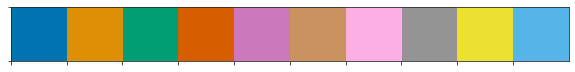

In [6]:
current_palette = sns.color_palette('colorblind')
sns.palplot(current_palette)

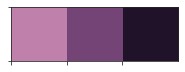

In [7]:
# cols = sns.cubehelix_palette(3, start=0, light=0.7, dark=0.3, rot=0.2)
cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)
sns.palplot(cols)

In [8]:
trace = pickle.load(open("traces/final_nov.pkl", "rb"))

# mitigation calculator csv

In [9]:
# csv file for mitigation calculator
cm_red = np.zeros((8000, 7))
cm_red[:, :] = trace.CMReduction[:, [0, 1, 2, 3, 4, 5, 7]]

# combine schools and unis into one NPI
cm_red[:, 5] = cm_red[:, 5] * trace.CMReduction[:, 6]

np.savetxt('traces.txt', cm_red, delimiter=',', header='Gatherings<1000, Gatherings<100, Gatherings<10, Some Business, Most Business, School+Uni, StayHome' )

# main results figure

In [10]:
country_noise = trace.CMAlphaScales * np.random.normal(size=(8000, 8))

'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


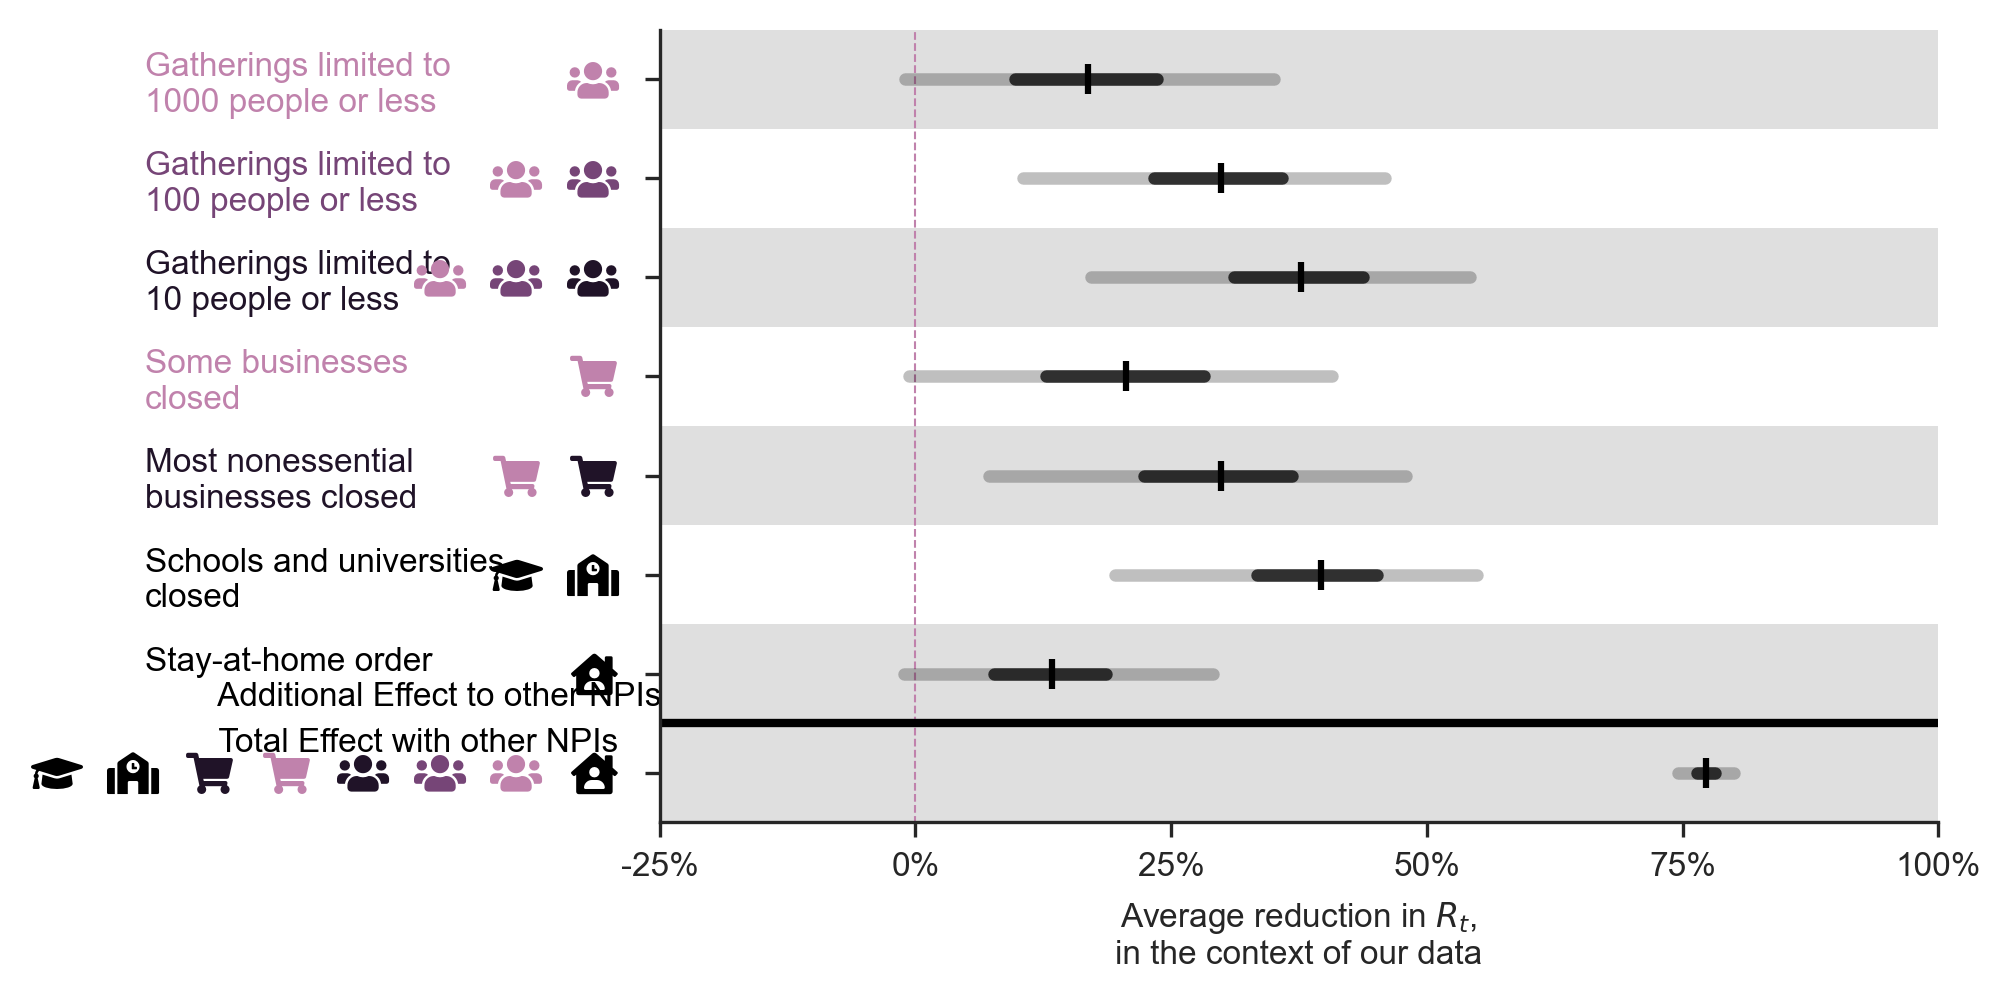

In [49]:
from matplotlib.gridspec import GridSpec

derived_features = [
 ("Gatherings limited to\n1000 people or less", [0]),
 ("Gatherings limited to\n100 people or less", [1, 0]),
 ("Gatherings limited to\n10 people or less", [2, 1, 0]),
 ("Some businesses\nclosed", [3]),
 ("Most nonessential\nbusinesses closed", [4, 3]),
 ("Schools and universities\nclosed", [5, 6]),
 ("Stay-at-home order\n        Additional Effect to other NPIs", [7]),  
 ("        Total Effect with other NPIs\n\n", [7, 0, 1, 2, 3, 4, 5, 6]),  
 ]

cm_plot_style = [
            ("\uf0c0", cols[0]), # ppl
            ("\uf0c0", cols[1]), # ppl
            ("\uf0c0", cols[2]), # ppl
            ("\uf07a", cols[0]), # shop 1
            ("\uf07a", cols[2]), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

features = [x for x, _ in derived_features]

country_noise = np.random.normal(size=(8000, 8)) * trace.CMAlphaScales
res = np.exp(np.log(trace.CMReduction))

nS, _ = res.shape
nF = len(derived_features)

derived_res = np.zeros((nS, nF))

for f_i, (f, prodrows) in enumerate(derived_features):
    samples = np.ones(nS)
    for r in prodrows:
        samples = samples * res[:, r] 
    derived_res[:, f_i] = samples

derived_res = 100*(1-derived_res)

def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq

mn, med, li, ui, lq, uq = produce_ranges(derived_res)

N_cms = mn.size

fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

fig = plt.figure(figsize=(5.5, 3.5), dpi=300)
ax1=plt.gca()

# gs = GridSpec(3, 2, figure=fig)
# ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=2, rowspan=2))

plt.plot([0, 0], [1, -(N_cms)], "--", color=cols[0], linewidth=0.5)
plt.plot([-100, 100], [-6.5, -6.5], color='k', linewidth=2)
y_vals = -1 * np.arange(N_cms)

xrange = np.array([-100, 100])
for height in range(0, nF, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
plt.fill_between(xrange, -(nF-1.5), -(nF+1.5), color="silver", alpha=0.5, linewidth=0)
    
plt.scatter(med, y_vals, marker="|", color="black", s=55)

for cm in range(N_cms):
    plt.plot([li[cm], ui[cm]], [y_vals[cm], y_vals[cm]], "black", alpha=0.25, linewidth=3)
    plt.plot([lq[cm], uq[cm]], [y_vals[cm], y_vals[cm]], "black", alpha=0.75, linewidth=3)

x_min = -25
x_max = 75
plt.xlim([x_min, x_max])
xtick_vals = [-25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.ylim([-(N_cms - 0.5), 0.5])

x_r = np.abs(x_min - x_max)
for cm in range(N_cms):
    for i, val in enumerate(derived_features[cm][1]):
        if val < len(cm_plot_style):
            col = cm_plot_style[val][1]
        else:
            col = "k"
        plt.text(x_min - 6.5 - 7.5*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                     fontproperties=fp2, fontsize=10, color=col)

ax = plt.gca()
plt.yticks(-np.arange(N_cms), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
yax = ax.get_yaxis()
yax.set_tick_params(pad=120)

for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
    if i < len(cm_plot_style):
            col = cm_plot_style[i][1]
    else:
        col = "k"
    ticklabel.set_color(col)

plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlabel("Average reduction in $R_t$,\nin the context of our data", fontsize=8)
# plt.text(0, -0.1, "Doubles\nTransmission", fontsize=6, ha='center', va='center',  transform=ax.transAxes, style='italic')
# plt.text(1, -0.1, "Ends\nTransmission", fontsize=6, ha='center',  va='center', transform=ax.transAxes, style='italic')
sns.despine()

# ax1 = plt.subplot(gs.new_subplotspec((2, 0), colspan=1, rowspan=1))
# data.conditional_activation_plot(cm_plot_style, newfig=False, skip_yticks=True,)

# ax1 = plt.subplot(gs.new_subplotspec((2, 1), colspan=1, rowspan=1))
# data.cumulative_days_plot(cm_plot_style, skip_yticks=True, newfig=False)

# plt.tight_layout()
plt.savefig("figs/FigureEF.pdf", bbox_inches="tight")

In [52]:
np.mean(trace.HyperRVar)

0.611404107899981

# Pareto Graphs

In [27]:
schools_index = data.CMs.index("School Closure")
uni_index = data.CMs.index("University Closure")

pkg_mask = np.ones(len(data.CMs))
pkg_mask[uni_index] = 0

In [28]:
stk = np.hstack([data.ActiveCMs[r, :, :] for r in range(len(data.Rs))])
unique_columns, counts = np.unique(stk, return_counts = True, axis=1)
nCMs, nPkgs = unique_columns.shape
n_active = np.zeros(nPkgs)
for p in range(nPkgs):
    n_active[p] = np.sum(unique_columns[:, p]*pkg_mask)
    if unique_columns[schools_index, p] == 1 and unique_columns[uni_index, p] == 0:
        counts[p] = 0
    
    if unique_columns[schools_index, p] == 0 and unique_columns[uni_index, p] == 1:
        counts[p] = 0

In [29]:
display_together = [1, 2, None, 4, None, None, None,None]

In [30]:
for d, dt in zip(data.CMs, display_together):
    print(d)
    if dt is not None:
        print(f"  with {data.CMs[dt]}")

Gatherings <1000
  with Gatherings <100
Gatherings <100
  with Gatherings <10
Gatherings <10
Some Businesses Suspended
  with Most Businesses Suspended
Most Businesses Suspended
School Closure
University Closure
Stay Home Order


In [31]:
def traverse(cm_i, pkg):
    dt = display_together[cm_i]
    
    if dt == None:
        return 0
    elif pkg[dt] == 0: 
        return 0
    elif pkg[dt] == 1:
        return 1 + traverse(dt, pkg)
    
    
def effective_active(pkg):
    n_active = 0
    for cm_i, cm in enumerate(pkg):
        if cm == 1:
            if traverse(cm_i, pkg) == 0:
                n_active += 1
    return n_active

In [32]:
import scipy.stats as ss

In [33]:
country_noise = np.random.normal(size=(8000, 8)) * trace.CMAlphaScales
res = np.exp(np.log(trace.CMReduction) - country_noise)
R_0 = 3.28 

In [34]:
unique_columns.shape

(8, 38)

In [35]:
np.argsort(counts)

array([18, 33, 28, 27, 34, 14, 10,  8, 17, 35,  1,  5,  2,  4, 32, 21, 31,
        6, 23, 26,  9, 12, 20, 11, 25, 24,  3, 13, 16, 15, 30,  7, 22, 19,
       36, 29, 37,  0])

# most common packages

In [36]:
order = np.argsort(n_active)[::-1]

In [37]:
order = np.argsort(counts)[::-1]

for oi in order:
    pkg = unique_columns[:, oi]
    nd = counts[oi]
    na = n_active[oi]
    
    if nd > 0 and na > 0:
        cm_str = [f"{data.CMs[i]} " if pkg[i] == 1 else "" for i in range(8)]
        print(f'{cm_str} N_d {nd} na {na}')

to_show_mask = counts>30
to_show_mask[0] = False

['Gatherings <1000 ', 'Gatherings <100 ', 'Gatherings <10 ', 'Some Businesses Suspended ', 'Most Businesses Suspended ', 'School Closure ', 'University Closure ', 'Stay Home Order '] N_d 1155 na 7.0
['Gatherings <1000 ', 'Gatherings <100 ', 'Gatherings <10 ', 'Some Businesses Suspended ', '', 'School Closure ', 'University Closure ', ''] N_d 548 na 5.0
['Gatherings <1000 ', 'Gatherings <100 ', 'Gatherings <10 ', 'Some Businesses Suspended ', 'Most Businesses Suspended ', 'School Closure ', 'University Closure ', ''] N_d 495 na 6.0
['Gatherings <1000 ', 'Gatherings <100 ', '', 'Some Businesses Suspended ', '', 'School Closure ', 'University Closure ', ''] N_d 176 na 4.0
['Gatherings <1000 ', 'Gatherings <100 ', '', 'Some Businesses Suspended ', 'Most Businesses Suspended ', 'School Closure ', 'University Closure ', ''] N_d 118 na 5.0
['Gatherings <1000 ', '', '', '', '', '', '', ''] N_d 85 na 1.0
['Gatherings <1000 ', 'Gatherings <100 ', 'Gatherings <10 ', 'Some Businesses Suspended ', 

'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


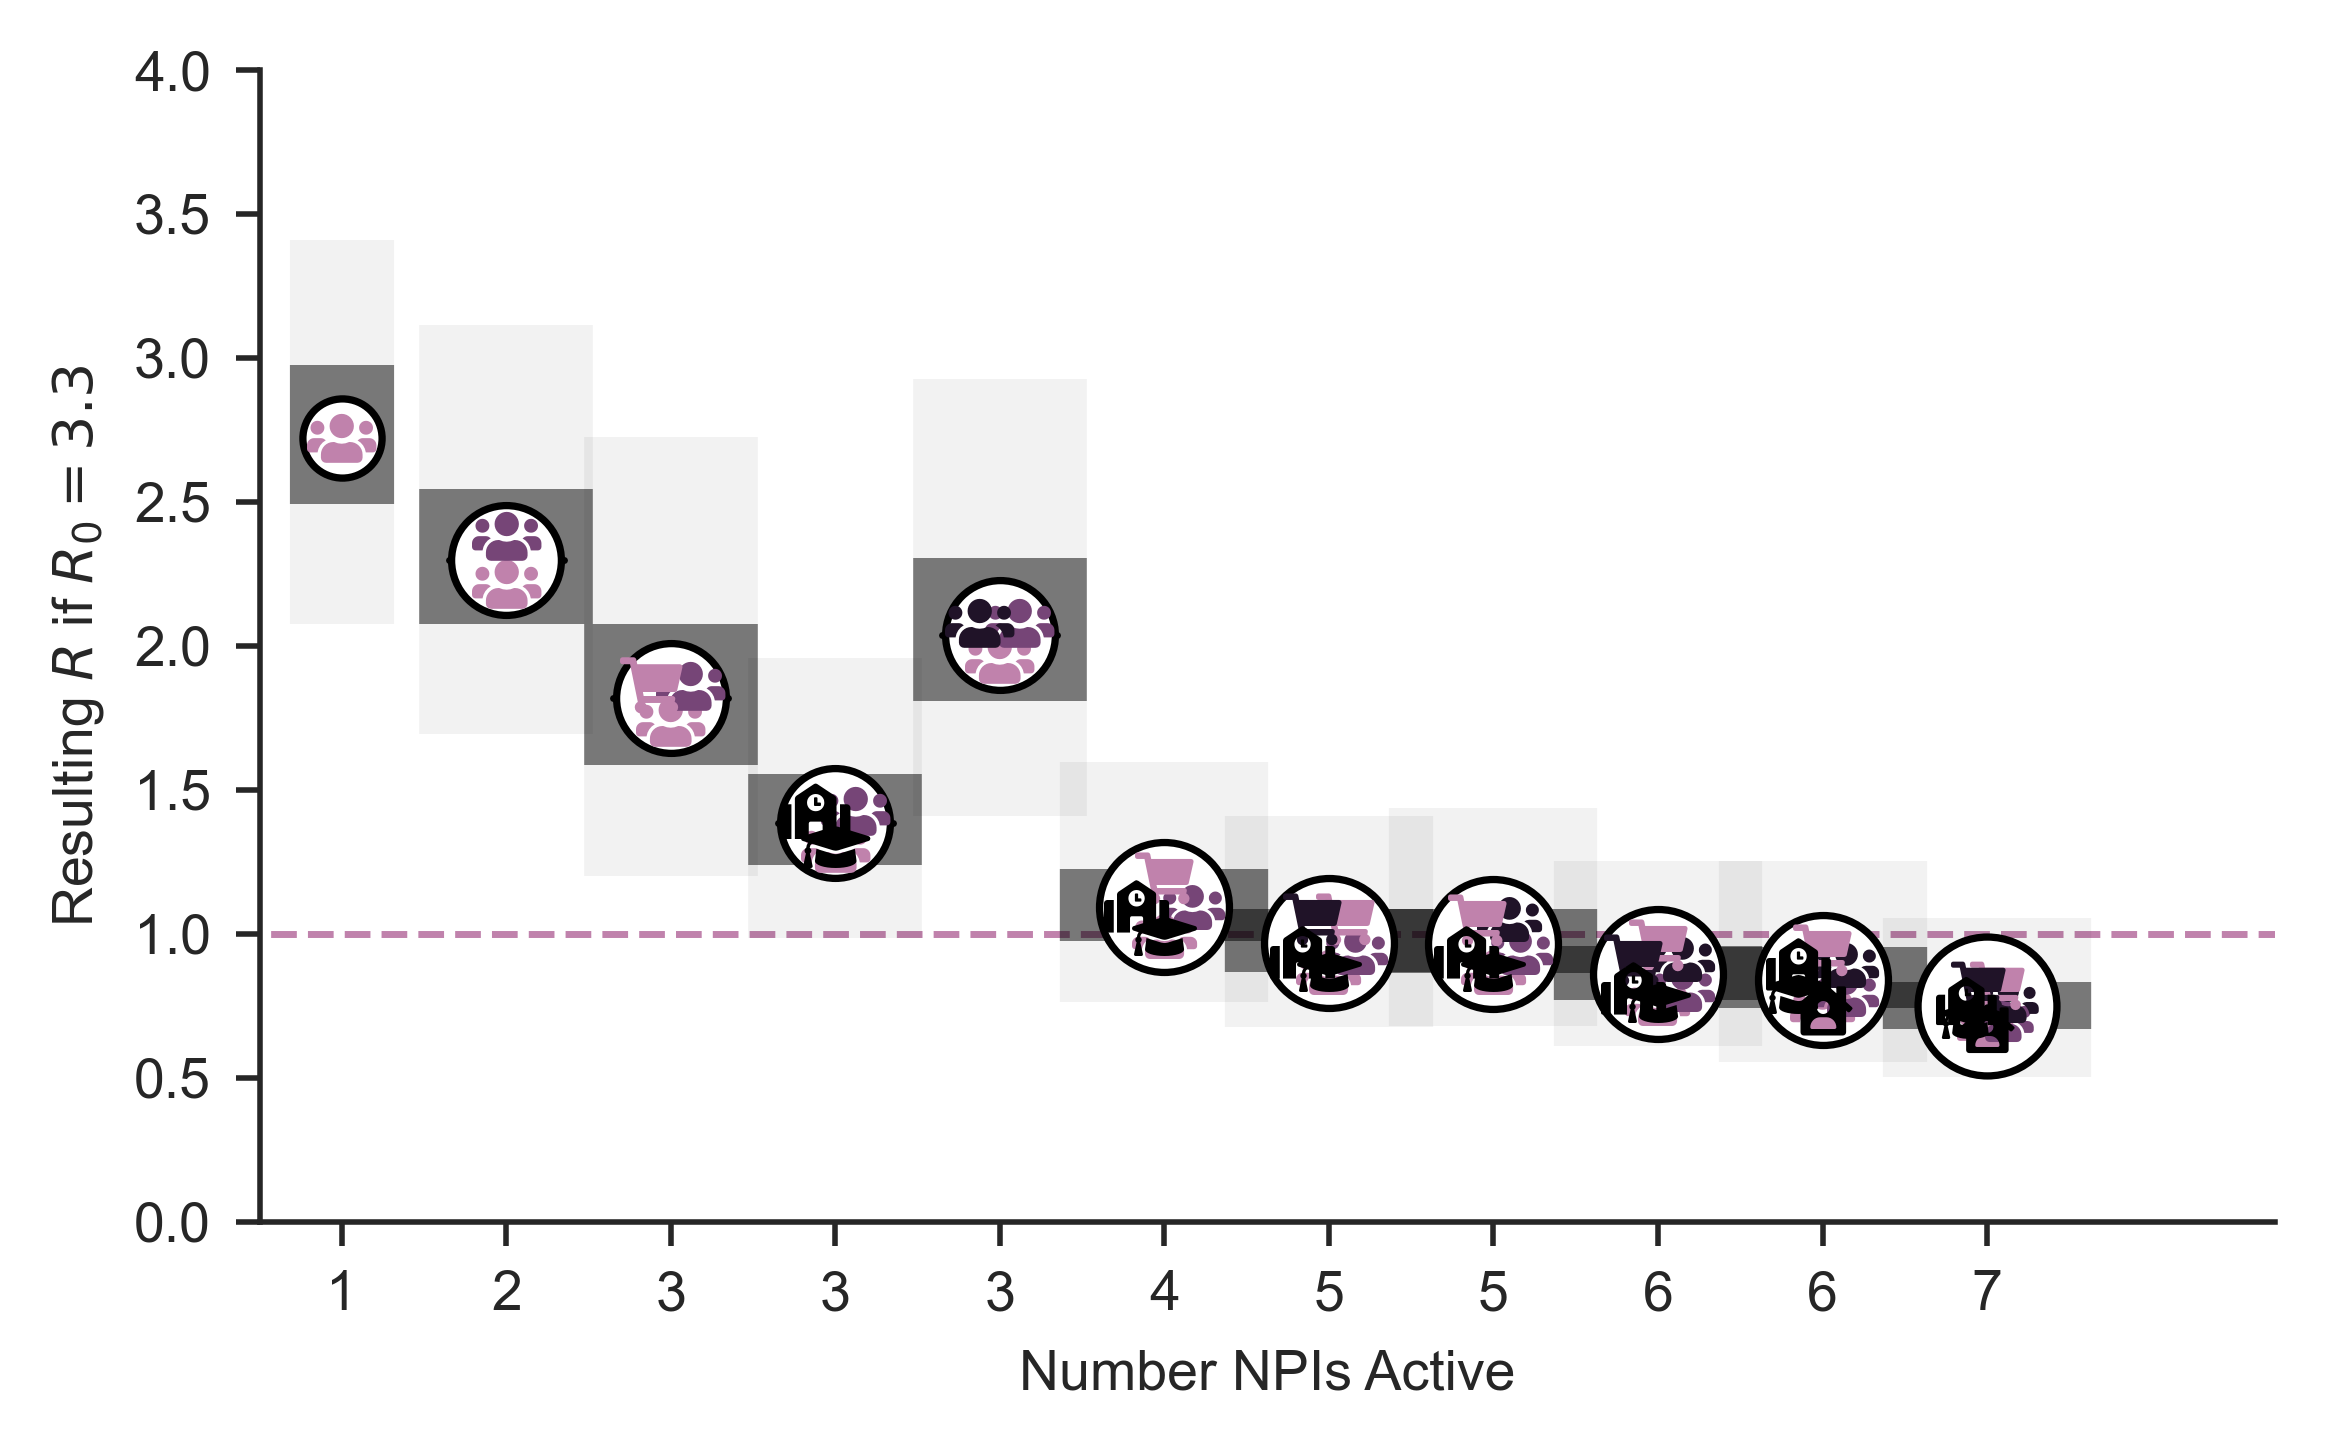

In [41]:
import seaborn as sns
sns.set_style("ticks")
colors = sns.color_palette()

fig = plt.figure(figsize=(4.75, 3), dpi=500)

# plt.subplot(121)
# for p in range(nPkgs):
#     pkg = unique_columns[:, p]
#     count_p = counts[p]
#     n_active_p = int(np.sum(pkg))
#     display_mc = 1
#     if np.sum(count_p < counts[n_active == n_active_p]) < display_mc:
#         if n_active_p > 0:
            
#             if n_active_p == 1:
#                 marker_size = 100*2
#                 text_size = 8
#                 r = 0.2
#             elif n_active_p < 4:
#                 marker_size = 300*2
#                 text_size = 8
#                 r = 0.22
#             elif n_active_p < 7:
#                 marker_size = 350*2
#                 text_size = 7.5
#                 r = 0.26
#             else:
#                 marker_size = 400*2
#                 text_size = 7
#                 r = 0.26
            
#             vals = np.ones(nS)
#             for c_i in range(nCMs):
#                 if pkg[c_i] != 0:
#                     vals = vals * trace.CMReduction[:, c_i]
#             R_vals = 0.999/vals
            
#             plt.scatter(n_active_p, np.median(R_vals), color="black", facecolor="white", s=marker_size, zorder=0, linewidth=0.5)
#             plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 2.5), np.percentile(R_vals, 97.5)], zorder=-1, color="lightgray", linewidth=28)
#             plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 25), np.percentile(R_vals, 75)], zorder=-1, color="gray", linewidth=28)
#             plt.plot([n_active_p-0.475, n_active_p+0.475], [np.percentile(R_vals, 50), np.percentile(R_vals, 50)], zorder=-3, color="black", linewidth=2)
            
#             if n_active_p > 1:
#                 points = [(np.cos(2*np.pi/n_active_p*x -np.pi/2)*r,np.sin((2*np.pi/n_active_p*x) -np.pi/2)*r) for x in range(0,n_active_p+1)]
#                 for c_i, c in enumerate(np.nonzero(pkg)[0].tolist()): 
#                     plt.text(n_active_p + points[c_i][0], np.median(R_vals) + points[c_i][1], cm_plot_style[c][0], zorder=2, color=cm_plot_style[c][1], fontproperties=fp2, ha="center", va="center", size=text_size)
#             else:
#                 nz = np.nonzero(pkg)[0].tolist()[0]
#                 plt.text(n_active_p , np.median(R_vals), cm_plot_style[nz][0], zorder=2, color=cm_plot_style[nz][1], fontproperties=fp2, ha="center", va="center", size=text_size)

# plt.xlabel("Number NPIs Active", fontsize=12)
# plt.ylabel("Maximum $R_0$\nthat can be brought below 1", fontsize=12)
# plt.xticks(np.arange(1, 10), fontsize=10)
# plt.yticks(fontsize=10)
# plt.ylim([0, 9])
# plt.xlim([0, 9.5])

# plt.subplot(122)
x = 1
order = np.argsort(n_active)

n_active_xlabels = []

for oi in range(nPkgs):
    p = order[oi]
    pkg = unique_columns[:, p]
    count_p = counts[p]
    n_active_p = int(np.sum(pkg*pkg_mask))
    if to_show_mask[p] and not (n_active_p == 1 and pkg[5] == 1):
        if n_active_p > 0:
            if n_active_p == 1:
                marker_size = 65*2
                text_size = 8
                r = 0.12
                lw = 15
                e = 0.22
            elif n_active_p < 4:
                marker_size = 125*2
                text_size = 8
                r = 0.14
                lw = 25
                e = 0.35
            elif n_active_p < 7:
                marker_size = 175*2
                text_size = 7.5
                r = 0.17
                lw = 30
                e = 0.3625
            else:
                marker_size = 200*2
                text_size = 7
                r = 0.13
                lw = 30
                e = 0.375
            
            vals = np.ones(8000)
            for c_i in range(nCMs):
                if pkg[c_i] != 0:
                    vals = vals * res[:, c_i]
            R_vals = R_0 * vals
            
            plt.scatter(x, np.median(R_vals), color="black", facecolor='white', s=marker_size, zorder=1, linewidth=1.05)
            plt.plot([x, x], [np.percentile(R_vals, 2.5), np.percentile(R_vals, 97.5)], zorder=-1, color="black",  alpha=0.05, linewidth=lw, solid_capstyle='butt')
            plt.plot([x, x], [np.percentile(R_vals, 25), np.percentile(R_vals, 75)], zorder=-1, color="black", alpha=0.5, linewidth=lw, solid_capstyle='butt') 
            plt.plot([x-e, x+e], [np.percentile(R_vals, 50), np.percentile(R_vals, 50)], zorder=0, color="black", linewidth=1)
            
            if n_active_p > 1 or (pkg[schools_index]==1 and n_active_p == 1):
                points = [(np.cos(2*np.pi/n_active_p*theta -np.pi/2)*r,np.sin((2*np.pi/n_active_p*theta) -np.pi/2)*r*0.6) for theta in range(0,n_active_p+1)]
                for c_i, c in enumerate(np.nonzero(pkg)[0].tolist()): 
                    plt.text(x + points[c_i][0], np.median(R_vals) + points[c_i][1], cm_plot_style[c][0], zorder=2, color=cm_plot_style[c][1], fontproperties=fp2, ha="center", va="center", size=text_size)
            else:
                nz = np.nonzero(pkg)[0].tolist()[0]
                plt.text(x, np.median(R_vals), cm_plot_style[nz][0], zorder=2, color=cm_plot_style[nz][1], fontproperties=fp2, ha="center", va="center", size=text_size)
            
            x += 1
            n_active_xlabels.append(n_active_p)

plt.ylim([0, 4])
plt.xlim([0.5, 12.75])
plt.plot([-1, 15], [1, 1], "--", linewidth=1, color=cols[0], zorder=-5)
plt.xlabel("Number NPIs Active", fontsize=8)
plt.ylabel("Resulting $R$ if $R_0=3.3$", fontsize=8)
plt.xticks(np.arange(1, len(n_active_xlabels)+1), n_active_xlabels, fontsize=8)
plt.yticks(fontsize=8)
sns.despine()
plt.tight_layout()

plt.savefig(f"figs/main/FigurePR.pdf", bbox_inches='tight')

In [ ]:
f;

# Numerical Values

In [ ]:
for cm_i, cm in enumerate(derived_features):
    print(f"{cm[0]}")
    print(f"  {np.mean(derived_res[:, cm_i]):.3f}% [{np.percentile(derived_res[:, cm_i], 2.5):.3f} ... {np.percentile(derived_res[:, cm_i], 50):.3f} ... {np.percentile(derived_res[:, cm_i], 97.5):.3f}] std: {np.std(derived_res[:, cm_i]):.3f}% Credence Positive: {100 * np.mean(derived_res[:, cm_i] > 0):.3f}%")

In [ ]:
reduction = 1-np.prod(trace.CMReduction, axis=1)

In [ ]:
100*np.median(reduction)

In [ ]:
100*np.percentile(reduction, 2.5)

In [ ]:
100*np.percentile(reduction, 97.5)

# Region Rs

In [ ]:
for r_i, r in enumerate(data.Rs):
    print(f"{r}: R_0 = {np.mean(trace.RegionR[:, r_i]):.2f} [{np.percentile(trace.RegionR[:, r_i], 2.5):.2f} ... {np.percentile(trace.RegionR[:, r_i], 97.5):.2f}]")

# Correlation Plot

In [ ]:
res = trace.CMReduction[:, [0, 1, 2, 3, 4, 5, 7]]
res[:, 6] = trace.CMReduction[:, 6] * res[:, 5]

cms = ["Gatherings <1000", "Gatherings <100", "Gatherings <10", "Some businesses closed", "Most businesses closed", "Schools and univeristies closed", "Stay-at-home order"]

In [ ]:
fig = plt.figure(figsize=(4, 3), dpi=300)
correlation = np.corrcoef(res, rowvar=False)
plt.imshow(correlation, cmap="PuOr", vmin=-1, vmax=1)
cbr = plt.colorbar()
cbr.ax.tick_params(labelsize=6)
plt.yticks(np.arange(N_cms), cms, fontsize=6)
plt.xticks(np.arange(N_cms), cms, fontsize=6, rotation=-30, ha="left")
plt.title("Posterior Correlation", fontsize=10);

plt.savefig(f"figs/main/FigureCorr.pdf", bbox_inches='tight')

In [ ]:
np.min(correlation)

In [ ]:
import arviz as az

In [ ]:
ep = EpidemiologicalParameters()

In [ ]:
ep.get_model_build_dict()

In [ ]:
import scipy.stats as stats

In [ ]:
varnames = ["GI_mean", "DeathsDelayMean", "CasesDelayMean", "GI_sd",  "DeathsDelayDisp", "CasesDelayDisp"]
titles = ['Generation Interval Mean',  'Infection to Death Delay Mean', 'Infection to Case-Confirmation Delay Mean', 'Generation Interval std.', 
          'Infection to Death Delay disp.', 'Infection to Case-Confirmation Delay disp.']

prior_means = [5.06, 21.81, 10.92, 2.11, 14.3, 5.4]
prior_stds = [0.3265, 1.00, 0.94, 0.5, 5.18, 0.269]
plt.figure(figsize=(7, 3), dpi=300)
for v_i, v in enumerate(varnames):
    plt.subplot(2, 3, v_i + 1)
    az.plot_kde(trace[v], plot_kwargs={'color':cols[0]}, label='posterior', ax=plt.gca())
    plt.title(titles[v_i], fontsize=8)
    
    l, u = plt.xlim()
    x = np.linspace(l, u, 500)
    d = stats.norm(loc=prior_means[v_i], scale=prior_stds[v_i])
    p = d.pdf(x)
    plt.plot(x, p, label='prior', color=cols[2])
    
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    if v_i == 0 or v_i == 3:
        plt.ylabel('density', fontsize=7)
    
    if v_i > 2:
        plt.xlabel('value', fontsize=7)
                
    if v_i == 0:
        plt.legend(fontsize=6, fancybox=True, shadow=True)
    else:
        plt.gca().get_legend().remove()

plt.tight_layout()
plt.savefig(f"figs/main/FigureEpiParamPosts.pdf", bbox_inches='tight')

# NPI Combinations

In [ ]:
trace.CMReduction.shape

In [ ]:
sc_comb_trace = np.zeros((8000, 8))
sc_comb_trace[:, :7] = trace.CMReduction[:, :7]
sc_comb_trace[:, 6] = trace.CMReduction[:, 6] * trace.CMReduction[:, 7]
sc_comb_trace[:, 7] = trace.CMReduction[:, 8]

In [ ]:
data.CMs

In [ ]:
requirements = [
    [],
    [],
    [1],
    [1, 2], 
    [],
    [4],
    [], 
    []
]

In [ ]:
import itertools
lst = list(itertools.product([0, 1], repeat=8))

In [ ]:
table = np.empty((0, 11))

for l in lst:
    cont = True
    
    for cm_i in range(8):
        for cm_req in requirements[cm_i]:
            if l[cm_req] == 0 and l[cm_i] == 1:
                cont = False
    
    if cont:
        comb_reduction = 100*(1-np.product(sc_comb_trace[:, np.array(l) == 1], axis=1))
        row = np.array([*l, np.percentile(comb_reduction, 50),  np.percentile(comb_reduction, 2.5),  np.percentile(comb_reduction, 97.5)]).reshape((1, 11))
        table = np.append(table, row, axis=0)

In [ ]:
header_str = ''

n = '\n'
for l, _ in derived_features:
    header_str = f'{header_str}{l.replace(n, " ")},'

header_str += 'median percentage reduction in R_t, lower 95% credible interval, upper 95% credible interval, '

In [ ]:
np.savetxt('NPI_combination_effects.csv', table, delimiter=',', header=header_str, fmt='%f')

In [ ]:
table.shape

In [ ]:
table

In [ ]:
np.array(l) == 1

# diagonostic plots

In [ ]:
import arviz as az

In [ ]:
ess = az.ess(trace)

In [ ]:
rhat = az.rhat(trace)

In [ ]:
trace.varnames

In [ ]:
def collate(stat):
    stat_all = []
    stat_nums = []
    for var in ["CMReduction", "GI_mean", "GI_sd", "GrowthCasesNoise", "GrowthDeathsNoise", "CasesDelayMean", "CasesDelayDisp",
                "InitialSizeDeaths_log", "InitialSizeCases_log", "DeathsDelayMean", "DeathsDelayDisp", "HyperRVar", "PsiCases",
                "PsiDeaths", "InfectedDeaths", "InfectedCases", "ExpectedDeaths", "ExpectedCases", "AllCMAlphaNoise", "CMAlphaScales"]:
        if stat[str(var)].size>1:
            stat_all.append(stat[str(var)].to_dataframe().to_numpy().flatten())
        else:
            stat_nums.append(float(stat[str(var)]))
    stat_all = np.concatenate(np.array(stat_all))
    stat_all = np.concatenate([stat_all, stat_nums])
#     stat_all[stat_all > 100] = 1
    return stat_all

In [ ]:
ess

In [ ]:
plt.figure(figsize=(7, 3), dpi=300)
plt.subplot(121)
plt.hist(collate(rhat), bins=40, color=cols[0])
plt.title("$\hat{R}$", fontsize=12)

plt.subplot(122)
plt.hist(collate(ess)/8000, bins=40, color=cols[0])
plt.xlim([0, 3.5])
plt.title("Relative ESS", fontsize=12)
plt.savefig(f"figs/main/FigureMCMCStats.pdf", bbox_inches='tight')

# Model Fit Graphs

In [ ]:
def epicurve_plot(region, start_d_i=30):
    r_i = data.Rs.index(region)
    
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]+3
    else:
        end_d_i = len(data.Ds)

    ec = trace.ExpectedDeaths[:, r_i]
    nS, nDs = ec.shape

    try:
        dist = pm.NegativeBinomial.dist(mu=ec, alpha=np.repeat(trace.PsiDeaths.reshape((nS, 1)), nDs, axis=-1))
        ec_output = dist.random()
    except ValueError:
        ec_output = 0 * ec
        means_d = means_d * 0
        lu_id = lu_id * 0
        up_id = up_id * 0

    means_expected_deaths, lu_ed, up_ed, _, _ = produce_CIs(
        ec_output
    )

    eco = trace.ExpectedCases[:, r_i]
    nS, nDs = eco.shape

    try:
        dist = pm.NegativeBinomial.dist(mu=eco, alpha=np.repeat(trace.PsiCases.reshape((nS, 1)), nDs, axis=-1))
        eco_output = dist.random()
    except ValueError:
        eco_output = 10**-10 * ec

    means_expected_cases, lu_ec, up_ec, _, _ = produce_CIs(
        eco_output
    )

    days = data.Ds
    days_x = np.arange(len(days))
    deaths = data.NewDeaths[r_i, :]
    cases = data.NewCases[r_i, :]

    ax = plt.gca()
    
    plt.plot(
        days_x,
        means_expected_deaths,
        label="Predicted Daily Deaths",
        zorder=2,
        color="tab:red"
    )

    plt.fill_between(
        days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
    )

    plt.scatter(
        days_x,
        deaths,
        label="Daily Deaths",
        marker="o",
        s=10,
        color="tab:red",
        alpha=0.9,
        zorder=3,
    )
    
    plt.plot(
        days_x,
        means_expected_cases,
        label="Predicted Daily Confirmed Cases",
        zorder=2,
        color="tab:blue"
    )

    plt.fill_between(
        days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
    )

    plt.scatter(
        days_x,
        cases,
        label="Daily Confirmed Cases",
        marker="o",
        s=10,
        color="tab:blue",
        alpha=0.9,
        zorder=3,
    )

    ax.set_yscale("log")
    plt.ylim([10 ** 0, 10 ** 6])
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    
    ax=plt.gca()
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(data.RNames[region][0], fontsize=12)
    
    return ax
    
def reprod_plot(r, start_d_i=30):
    r_i = data.Rs.index(r)
    
    nS, nCMs = trace.CM_Alpha.shape
    nDs = len(data.Ds)
    
    
    ActiveCMRed = np.sum(data.ActiveCMs[r_i, :, : ].reshape((1, nCMs, nDs)) * trace.CM_Alpha.reshape((nS, nCMs, 1)), axis=1)    
    RegionR = trace['RegionR'][:, r_i]

    rs = np.exp(np.log(RegionR.reshape((nS, 1))) - ActiveCMRed)
    
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]+3
    else:
        end_d_i = len(data.Ds)
    
    days_x = np.arange(len(data.Ds))
    
    
    mns, lu, up, _, _ = produce_CIs(
        rs
    )
    
    plt.plot(days_x, mns, color=cols[0])
    plt.fill_between(
        days_x, lu, up, alpha=0.25, color=cols[0], linewidth=0
    )
    
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    plt.ylim([0, 5])
    plt.plot([start_d_i, end_d_i], [1, 1], color=cols[1])
    plt.ylabel("$R_t$", fontsize=10)
    ax=plt.gca()
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(data.RNames[r][0], fontsize=12)
    
def month_to_str(x):
    if x == 1:
        return "JAN"
    if x == 2:
        return "FEB"
    if x == 3:
        return "MAR"
    if x == 4:
        return "APR"
    if x == 5:
        return "MAY"
    

In [ ]:
import pymc3 as pm

rs = ["GB", "IT"]
plt.figure(figsize=(8, 8), dpi=300)

plt.subplot(221)
epicurve_plot(rs[0])

plt.subplot(222)
reprod_plot(rs[0])

plt.subplot(223)
ax = epicurve_plot(rs[1])

plt.subplot(224)
reprod_plot(rs[1])


plt.tight_layout()


ax.legend(shadow=True, fancybox=True, loc = "upper center", bbox_to_anchor = (1.15, -0.15), fontsize=8, ncol=2)

plt.savefig(f"figs/main/FigureFits.pdf", bbox_inches='tight')

In [ ]:
f;

# Conditioning Videos

In [ ]:
def condition_on(results, cm_index, value):
    copy_res = copy.deepcopy(results)
    remaining_res = np.delete(copy_res, cm_index, axis=1)
    
    cms = np.arange(8)

    cms_remaining = np.delete(cms, cm_index)
    res_mat = np.zeros((nS, nCMs))
    res_mat[:, -1] = copy_res[:, cm_index]
    res_mat[:, :-1] = remaining_res 
    
    mu = np.mean(100*(1-res_mat), axis=0)
    cov = np.cov(100*(1-res_mat), rowvar=False)
    
    m_1 = mu[:nCMs-1]
    m_2 = mu[-1]
    s_11 = cov[:nCMs-1, :nCMs-1]
    s_12 = cov[:nCMs-1, -1]
    s_22 = cov[-1, -1]
    
    mu_bar = m_1 + s_12 * (s_22**-1) * (value - m_2)
    sigma_bar = s_11 - (1/s_22) * s_12 @ s_12.T
    
    low = mu_bar - 1.96*np.diag(sigma_bar)**0.5
    high = mu_bar + 1.96*np.diag(sigma_bar)**0.5
    
    return (mu_bar, low, high, cms_remaining.tolist())

In [ ]:
np.mean(res, axis=0)

In [ ]:
CMs = ['Mask wearing',
 'Gatherings <1000',
 'Gatherings <100',
 'Gatherings <10',
 'Some businesses closed',
 'Most businesses closed',
 'Schools and universities closed',
 'Stay-at-home order']

nCMs = len(CMs) 

In [ ]:
npi = 0

fig = plt.figure(figsize=(5, 3), dpi=300)

x_min = -25
x_max = 75
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 1.96*stds[cm], mu[cm] + 1.96*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color(cols[0])
plt.xlabel('Average reduction in $R$,\n in the context of our data.', fontsize=8)
plt.text(35, -0.05, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=5.5, va="center", weight="bold")   
plt.title(f"Approximate Posterior\nConditioned on {CMs[npi]}", fontsize=10)

def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (1.96*stds[which_cm] * 2*float(i)/n_frames) - 1.96*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color(cols[0])
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
stds

In [ ]:
npi = 1

fig = plt.figure(figsize=(5, 3), dpi=300)

x_min = -25
x_max = 75
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 1.96*stds[cm], mu[cm] + 1.96*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color(cols[0])
plt.xlabel('Average reduction in $R$,\n in the context of our data.', fontsize=8)
plt.text(35, -0.05, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=5.5, va="center", weight="bold")   
plt.title(f"Approximate Posterior\nConditioned on {CMs[npi]}", fontsize=10)

def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (1.96*stds[which_cm] * 2*float(i)/n_frames) - 1.96*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color(cols[0])
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 2

fig = plt.figure(figsize=(5, 3), dpi=300)

x_min = -25
x_max = 75
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 1.96*stds[cm], mu[cm] + 1.96*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color(cols[0])
plt.xlabel('Average reduction in $R$,\n in the context of our data.', fontsize=8)
plt.text(35, -0.05, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=5.5, va="center", weight="bold")   
plt.title(f"Approximate Posterior\nConditioned on {CMs[npi]}", fontsize=10)

def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (1.96*stds[which_cm] * 2*float(i)/n_frames) - 1.96*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color(cols[0])
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 3

fig = plt.figure(figsize=(5, 3), dpi=300)

x_min = -25
x_max = 75
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 1.96*stds[cm], mu[cm] + 1.96*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color(cols[0])
plt.xlabel('Average reduction in $R$,\n in the context of our data.', fontsize=8)
plt.text(35, -0.05, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=5.5, va="center", weight="bold")   
plt.title(f"Approximate Posterior\nConditioned on {CMs[npi]}", fontsize=10)

def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (1.96*stds[which_cm] * 2*float(i)/n_frames) - 1.96*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color(cols[0])
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 4

fig = plt.figure(figsize=(5, 3), dpi=300)

x_min = -25
x_max = 75
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 1.96*stds[cm], mu[cm] + 1.96*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color(cols[0])
plt.xlabel('Average reduction in $R$,\n in the context of our data.', fontsize=8)
plt.text(35, -0.05, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=5.5, va="center", weight="bold")   
plt.title(f"Approximate Posterior\nConditioned on {CMs[npi]}", fontsize=10)

def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (1.96*stds[which_cm] * 2*float(i)/n_frames) - 1.96*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color(cols[0])
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 5

fig = plt.figure(figsize=(5, 3), dpi=300)

x_min = -25
x_max = 75
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 1.96*stds[cm], mu[cm] + 1.96*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color(cols[0])
plt.xlabel('Average reduction in $R$,\n in the context of our data.', fontsize=8)
plt.text(35, -0.05, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=5.5, va="center", weight="bold")   
plt.title(f"Approximate Posterior\nConditioned on {CMs[npi]}", fontsize=10)

def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (1.96*stds[which_cm] * 2*float(i)/n_frames) - 1.96*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color(cols[0])
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 6

fig = plt.figure(figsize=(5, 3), dpi=300)

x_min = -25
x_max = 75
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 1.96*stds[cm], mu[cm] + 1.96*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color(cols[0])
plt.xlabel('Average reduction in $R$,\n in the context of our data.', fontsize=8)
plt.text(35, -0.05, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=5.5, va="center", weight="bold")   
plt.title(f"Approximate Posterior\nConditioned on {CMs[npi]}", fontsize=10)

def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (1.96*stds[which_cm] * 2*float(i)/n_frames) - 1.96*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color(cols[0])
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 7

fig = plt.figure(figsize=(5, 3), dpi=300)

x_min = -25
x_max = 75
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 1.96*stds[cm], mu[cm] + 1.96*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color(cols[0])
plt.xlabel('Average reduction in $R$,\n in the context of our data.', fontsize=8)
plt.text(35, -0.05, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=5.5, va="center", weight="bold")   
plt.title(f"Approximate Posterior\nConditioned on {CMs[npi]}", fontsize=10)

def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (1.96*stds[which_cm] * 2*float(i)/n_frames) - 1.96*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color(cols[0])
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())